# Notebook to generate orthogonality plots

In [89]:
"""Imports."""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from pathlib import Path

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12766/2602849077.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12766/2602849077.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')


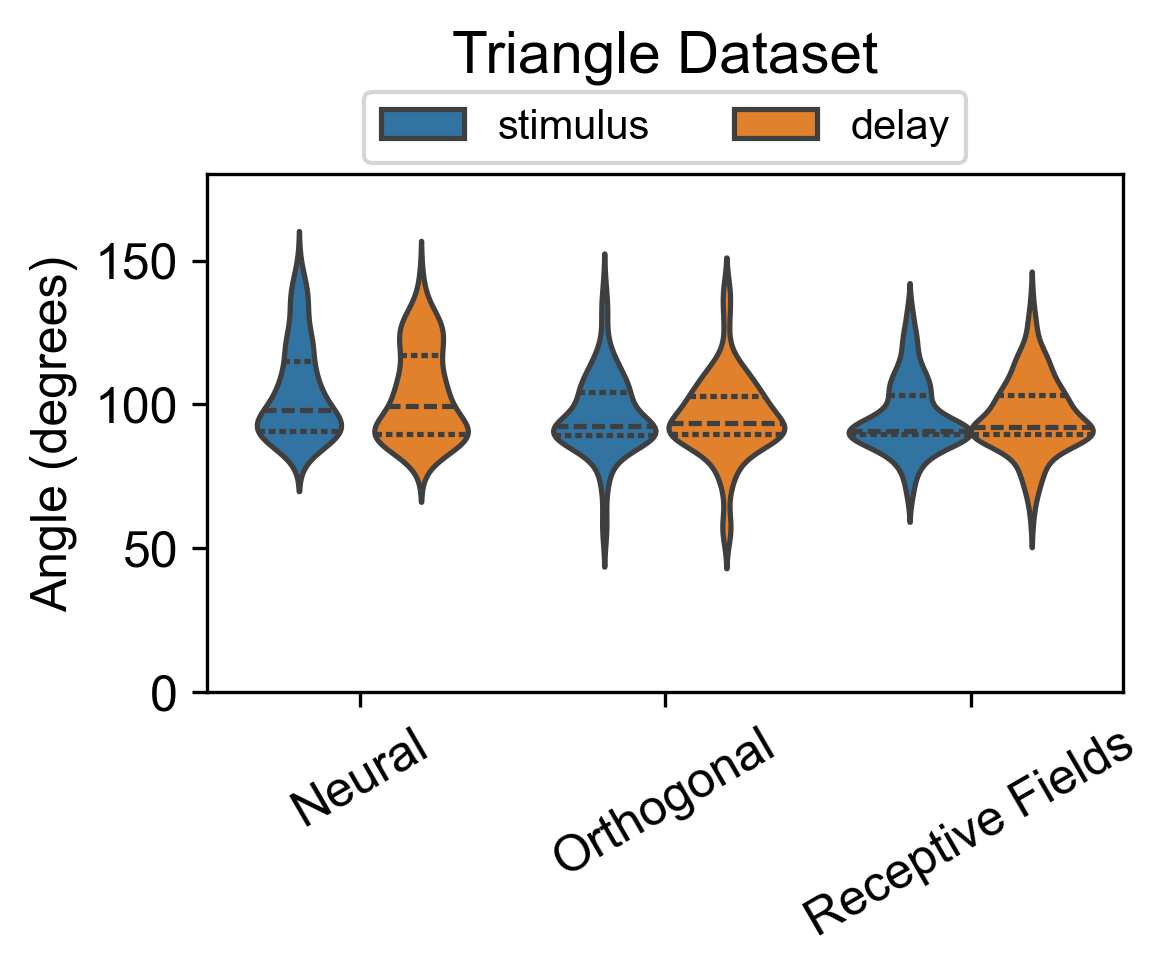

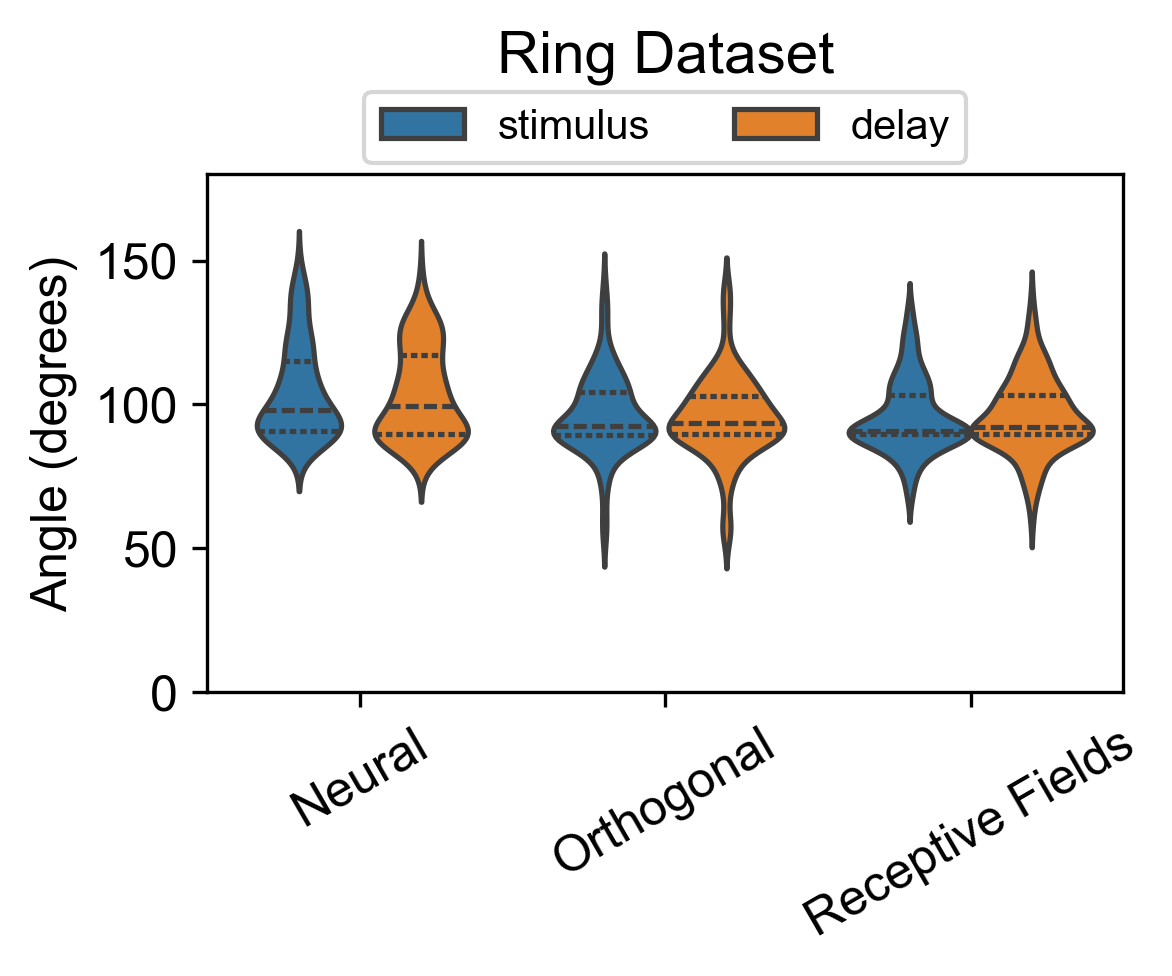

In [97]:
"""Load results dataframe."""

BASE_RESULTS_DIR = Path("../../../cache/figures/supp_fig_decoding")

_MODE_TO_NAME = {
    "neural": "Neural",
    "orthogonal": "Orthogonal",
    "receptive_fields": "Receptive Fields",
}

# Load data
df = {
    "dataset": [],
    "phase": [],
    "mode": [],
    "subject": [],
    "session": [],
    "phase": [],
    "shuffle_labels": [],
    "seed": [],
    "feature_index": [],
    "angle_degrees": [],
}
for dataset in ["2_triangle", "2_ring"]:
    for mode_dir in (BASE_RESULTS_DIR / dataset).iterdir():
        mode = mode_dir.name
        for session_phase in (mode_dir / f"feature=position").iterdir():
            subject = session_phase.stem.split("_")[0]
            session = session_phase.stem.split("_")[1]
            phase = session_phase.stem.split("_")[2]

            for shuffle in [False, True]:
                shuffle_dir = session_phase / f"shuffle_labels={int(shuffle)}"
                for seed_dir in shuffle_dir.iterdir():
                    seed = int(seed_dir.name)
                    bias_0 = np.load(seed_dir / "linear_0_bias.npy")
                    weight_0 = np.load(seed_dir / "linear_0_weights.npy")
                    bias_1 = np.load(seed_dir / "linear_1_bias.npy")
                    weight_1 = np.load(seed_dir / "linear_1_weights.npy")
                    n_features = weight_0.shape[0]
                    for i in range(n_features):
                        w0 = weight_0[i, :]
                        w1 = weight_1[i, :]
                        cos_sim = np.dot(w0, w1) / (np.linalg.norm(w0) * np.linalg.norm(w1))
                        angle = np.arccos(cos_sim) * 180 / np.pi
                        df["dataset"].append(dataset)
                        df["mode"].append(_MODE_TO_NAME[mode])
                        df["subject"].append(subject)
                        df["session"].append(session)
                        df["phase"].append(phase)
                        df["shuffle_labels"].append(shuffle)
                        df["seed"].append(seed)
                        df["feature_index"].append(i)
                        df["angle_degrees"].append(angle)
df = pd.DataFrame(df)

for dataset in df['dataset'].unique():
    dataset_df = df[df['dataset'] == dataset]
    fig, ax = plt.subplots(figsize=(4, 3.5))
    x_order = ["Neural", "Orthogonal", "Receptive Fields"]
    sns.violinplot(
        data=df[df.shuffle_labels == False],
        ax=ax,
        x="mode",
        y="angle_degrees",
        inner="quartile",
        order=x_order,
        # legend=False,
        hue="phase",
    )
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
    ax.set_xlabel("")
    ax.set_ylabel("Angle (degrees)")
    ax.set_ylim(0, 180)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
    ax.set_title(f"{dataset.split('_')[1].capitalize()} Dataset", y=1.15)

    # Save figure
    fig.tight_layout()
    fig.savefig(f'./{dataset}_orthogonality.pdf', bbox_inches='tight', pad_inches=0.01)